# INTRODUCTION

The following is a an attempt at predicitng house prices in the Ames, Iowa dataset and is a submission to the related Kaggle competition. The focus of this code is to compare a range of regression models when trained on the original target (house price) data vs when trained on the log transformed target data to make it have a closer distribution to a Gaussian normal distribution.

Without further ado, let's crack on and load the preliminaries.............

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler, LabelEncoder,OrdinalEncoder,power_transform
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV, ElasticNetCV, LassoCV,BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# DATA PREPROCESSING
Let's read in the train and test datasets into dataframes using pandas and take a look at a summary of what they consist of...

In [2]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

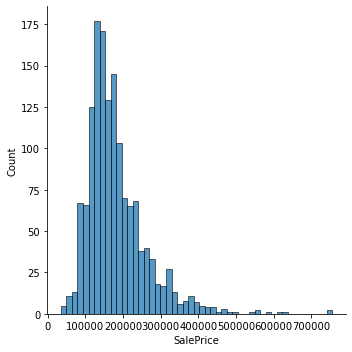

In [5]:
sns.displot(train['SalePrice']);
train['SalePrice'].describe()

We can clearly see the target (house price) data is skewed and has the potential to be more normally distributed which should help (at least some of) our model's performance. Let's log transform it and see what we get.......

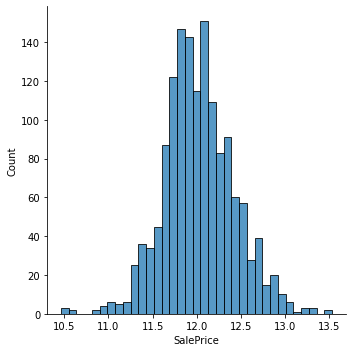

In [6]:
sns.displot(np.log(train["SalePrice"]));

That seems to have worked and given it a much more Gaussian normal distribution. Let's remember that for later.

For now let's investigate the independant variables and their correlations wiht the target.

The folloiwng plots a correlation matrix of the top 1o most highly correlated variables with the target (as well as then their inercorrelations)

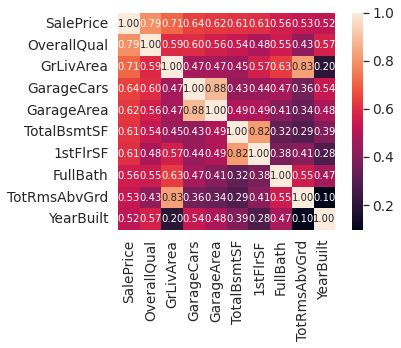

In [7]:
corrmat = train.corr()
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

From this we can see it looks like ***OverllQual*** and ***GrLivArea*** are instant top picks that also make logical sense when thinking about house prices. However, ***GrLivArea*** also obviously has high correlation with TotRmsAbvGrd so I will not choose the latter.

GarageCars and GarageArea are next on the list but are also highly intercorrelated so I will only be choosing ***GarageCars*** as it has a slightly higher correlation with the target.

Then there's TotalBsmtSF and 1stFlrSF which are both intercorrelated as we might expect so I will only be taking ***TotalBsmtSF***

Then last of all there is ***FullBath*** and ***YearBuilt*** which don't have particularly high correlations wiht other features so I'll be using both of these.

In [8]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

Let's see how they all look when plotted against each other........

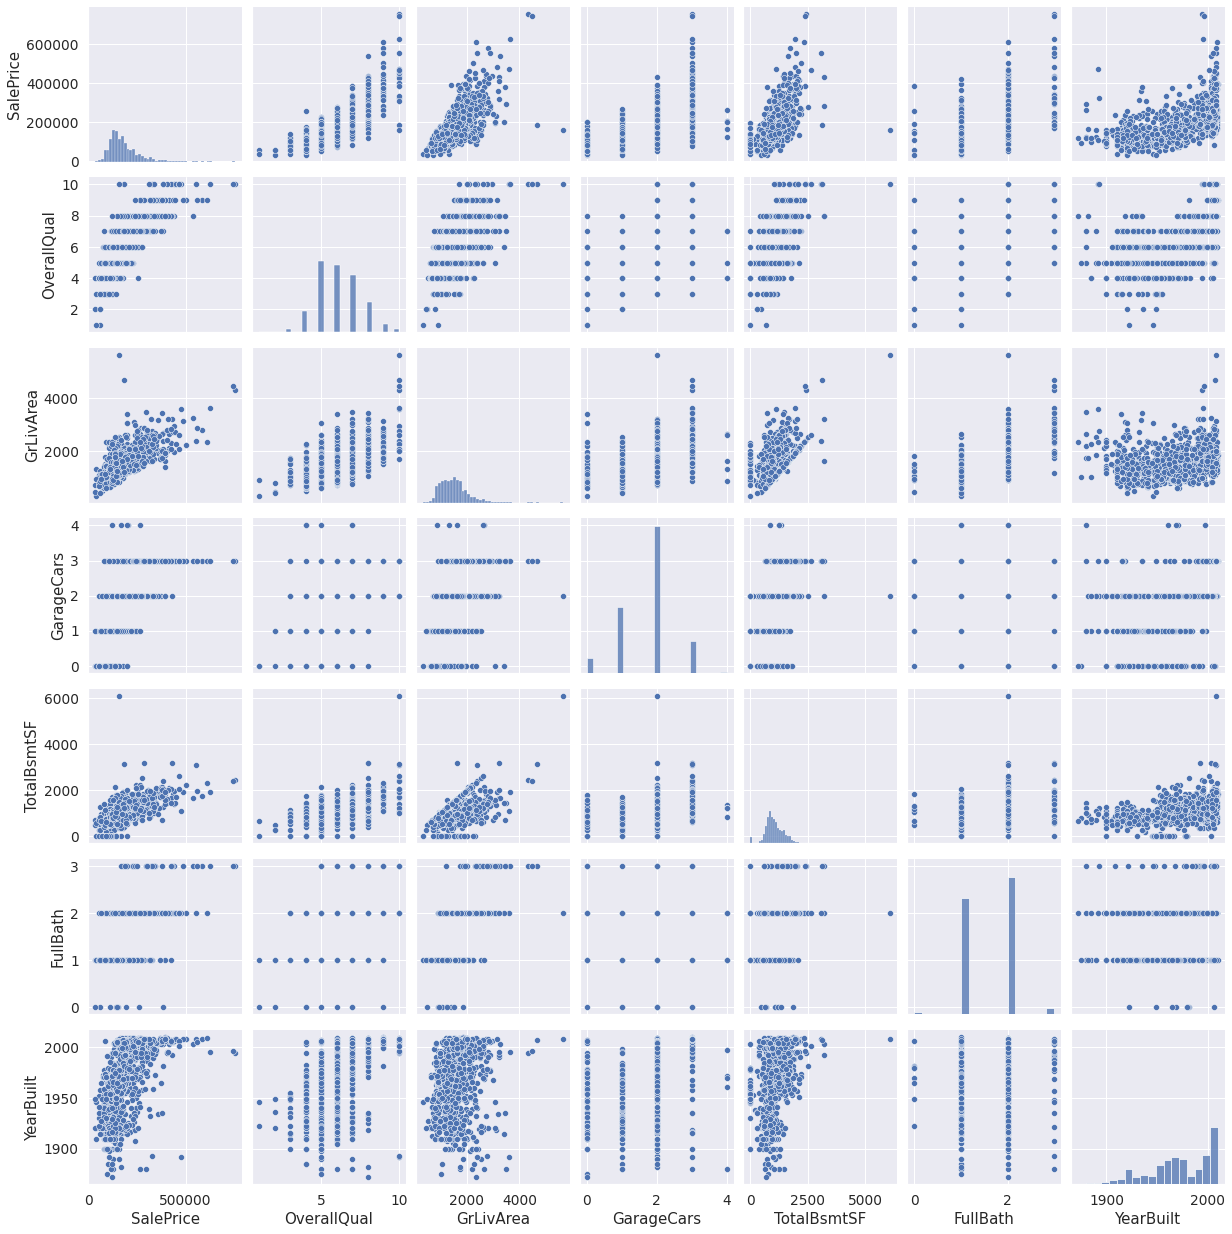

In [9]:
sns.pairplot(train[cols], height = 2.5)

There are clearly two significant outiars in GrLivArea and one in TotalBsmtSF when plotted against the SalePrice target so let's remove them. By eyeballing the plot I reckon we can eliminate the two associated with GrLivArea by setting a limit of about 4400.

In [10]:
train = train[train.GrLivArea <4400]

Let's see if that worked.......

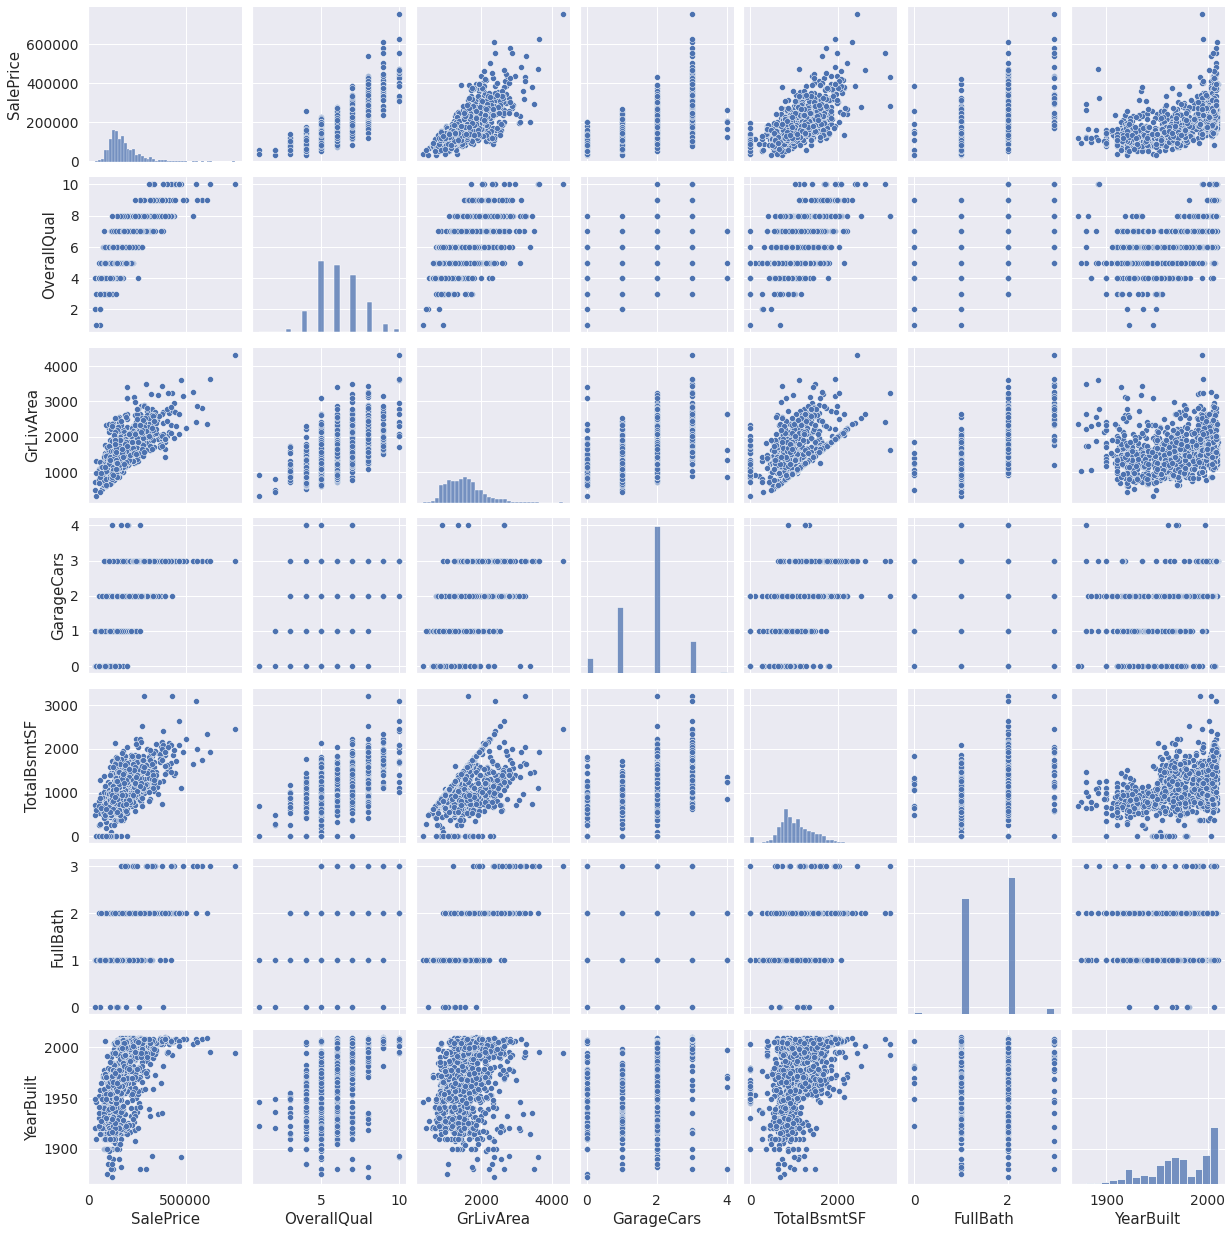

In [11]:
sns.pairplot(train[cols], height = 2.5)

That seems to have done the trick and luckily also seems to have simultaneously removed the TotalBsmtSF outliar as well. Bonus!

Enough EDA, let's set up our train and test sets with these handpicked features and check for null values

In [12]:
X_cols = cols.copy()
X_cols.remove("SalePrice")
print("****  X_train  ****")
X_train = train[X_cols]
X_train.info()
print("\n****  X_test  ****")
X_test = test[X_cols]
X_test.info()

****  X_train  ****
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1457 non-null   int64
 1   GrLivArea    1457 non-null   int64
 2   GarageCars   1457 non-null   int64
 3   TotalBsmtSF  1457 non-null   int64
 4   FullBath     1457 non-null   int64
 5   YearBuilt    1457 non-null   int64
dtypes: int64(6)
memory usage: 112.0 KB

****  X_test  ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OverallQual  1459 non-null   int64  
 1   GrLivArea    1459 non-null   int64  
 2   GarageCars   1458 non-null   float64
 3   TotalBsmtSF  1458 non-null   float64
 4   FullBath     1459 non-null   int64  
 5   YearBuilt    1459 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 68.5 KB


Train data looks ok but we have a couple of null values in GarageCars and TotalBsmtSF of the test data which I am happy with simly replaceing wiht 0

In [13]:
X_test = pd.DataFrame(X_test).fillna(0)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OverallQual  1459 non-null   int64  
 1   GrLivArea    1459 non-null   int64  
 2   GarageCars   1459 non-null   float64
 3   TotalBsmtSF  1459 non-null   float64
 4   FullBath     1459 non-null   int64  
 5   YearBuilt    1459 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 68.5 KB


Sorted!

Now let's define our train target data and check it looks OK

In [14]:
y_train = train["SalePrice"]
pd.DataFrame(y_train).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   SalePrice  1457 non-null   int64
dtypes: int64(1)
memory usage: 55.1 KB


Lastly, before training we should scale our features as they all have very different scales.

In [15]:
X_sc = RobustScaler()
X_train = X_sc.fit_transform(X_train)
X_test = X_sc.transform(X_test)

# MODEL TRAINING

Finally, let's train some models and see which one works best with it's "out of the box" default hyperparameters.

As mentioend at the start, for each model I will train it twice, once on the original target and a second time with the target log transformed as we saw early the better Gaussian like distribution this achieved. I'll ne using 5 fold cross validation on the whole training dataset and assessing performance using the best root mean squared error (RMSE) for each of the following models:

* linear regressor
* Decision Tree regressor
* Random Forest regressor
* K Nearest Neighbors regressor
* Gradient Boosting regressor 
* EXtreme Gradient Boosting regressor
* Support Vector regressor

In [16]:
model_comp={}

In [17]:
LR_model = LinearRegression()

LR_scores = cross_val_score(LR_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
LR_mean_score = LR_scores.mean()
LR_std_score = LR_scores.std()
print(f"RMSE = {LR_scores}")
print(f"Mean RMSE = {LR_mean_score:.2f}")
print(f"StDev RMSE = {LR_std_score:.2f}")

model_comp['LR']=[LR_mean_score, LR_std_score]

RMSE = [-31947.33780349 -31415.11966371 -39796.67814332 -33544.59745514
 -33413.18645353]
Mean RMSE = -34023.38
StDev RMSE = 3001.52


In [18]:
LR_model_norm = LinearRegression()

LR_with_trans_target = TransformedTargetRegressor(
    regressor=LR_model_norm, func=np.log, inverse_func=np.exp)

LR_scores_norm = cross_val_score(LR_with_trans_target, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
LR_mean_score_norm = LR_scores_norm.mean()
LR_std_score_norm = LR_scores_norm.std()
print(f"RMSE = {LR_scores_norm}")
print(f"Mean RMSE = {LR_mean_score_norm:.2f}")
print(f"StDev RMSE = {LR_std_score_norm:.2f}")

model_comp['LR_norm']=[LR_mean_score_norm, LR_std_score_norm]

RMSE = [-28208.98886702 -27171.9000077  -29965.34778439 -27006.15215299
 -28359.09694708]
Mean RMSE = -28142.30
StDev RMSE = 1059.01


In [19]:
DT_model = DecisionTreeRegressor(random_state=0)

DT_scores = cross_val_score(DT_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
DT_mean_score = DT_scores.mean()
DT_std_score = DT_scores.std()
print(f"RMSE = {DT_scores}")
print(f"Mean RMSE = {DT_mean_score:.2f}")
print(f"StDev RMSE = {DT_std_score:.2f}")

model_comp['DT']=[DT_mean_score, DT_std_score]

RMSE = [-40154.84770552 -38695.64693833 -42235.13514262 -35498.0933545
 -40467.82993132]
Mean RMSE = -39410.31
StDev RMSE = 2256.92


In [20]:
DT_model_norm = DecisionTreeRegressor(random_state=0)

DT_with_trans_target = TransformedTargetRegressor(
    regressor=DT_model_norm, func=np.log, inverse_func=np.exp)

DT_scores_norm = cross_val_score(DT_with_trans_target, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
DT_mean_score_norm = DT_scores_norm.mean()
DT_std_score_norm = DT_scores_norm.std()
print(f"RMSE = {DT_scores_norm}")
print(f"Mean RMSE = {DT_mean_score_norm:.2f}")
print(f"StDev RMSE = {DT_std_score_norm:.2f}")

model_comp['DT_norm']=[DT_mean_score_norm, DT_std_score_norm]

RMSE = [-42756.10088271 -40600.53199938 -42060.59404631 -36907.2543197
 -40536.35796735]
Mean RMSE = -40572.17
StDev RMSE = 2020.82


In [21]:
RF_model = RandomForestRegressor(random_state=0)

RF_scores = cross_val_score(RF_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
RF_mean_score = RF_scores.mean()
RF_std_score = RF_scores.std()
print(f"RMSE = {RF_scores}")
print(f"Mean RMSE = {RF_mean_score:.2f}")
print(f"StDev RMSE = {RF_std_score:.2f}")

model_comp['RF']=[RF_mean_score, RF_std_score]

RMSE = [-30793.02890785 -27886.73657523 -33730.90627634 -25181.71667026
 -30241.68165384]
Mean RMSE = -29566.81
StDev RMSE = 2875.78


In [22]:
RF_model_norm = RandomForestRegressor(random_state=0)

RF_with_trans_target = TransformedTargetRegressor(
    regressor=RF_model_norm, func=np.log, inverse_func=np.exp)

RF_scores_norm = cross_val_score(RF_with_trans_target, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
RF_mean_score_norm = RF_scores_norm.mean()
RF_std_score_norm = RF_scores_norm.std()
print(f"RMSE = {RF_scores_norm}")
print(f"Mean RMSE = {RF_mean_score_norm:.2f}")
print(f"StDev RMSE = {RF_std_score_norm:.2f}")

model_comp['RF_norm']=[RF_mean_score_norm, RF_std_score_norm]

RMSE = [-31296.08888314 -28670.98748886 -35143.67613773 -24416.0411363
 -29482.89824017]
Mean RMSE = -29801.94
StDev RMSE = 3497.30


In [23]:
KN_model = KNeighborsRegressor()

KN_scores = cross_val_score(KN_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
KN_mean_score = KN_scores.mean()
KN_std_score = KN_scores.std()
print(f"RMSE = {KN_scores}")
print(f"Mean RMSE = {KN_mean_score:.2f}")
print(f"StDev RMSE = {KN_std_score:.2f}")

model_comp['KN']=[KN_mean_score, KN_std_score]

RMSE = [-33439.48443033 -31534.90764674 -34314.85329827 -26730.72469615
 -29530.40821369]
Mean RMSE = -31110.08
StDev RMSE = 2740.49


In [24]:
KN_model_norm = KNeighborsRegressor()

KN_with_trans_target = TransformedTargetRegressor(
    regressor=KN_model_norm, func=np.log, inverse_func=np.exp)

KN_scores_norm = cross_val_score(KN_with_trans_target, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
KN_mean_score_norm = KN_scores_norm.mean()
KN_std_score_norm = KN_scores_norm.std()
print(f"RMSE = {KN_scores_norm}")
print(f"Mean RMSE = {KN_mean_score_norm:.2f}")
print(f"StDev RMSE = {KN_std_score_norm:.2f}")

model_comp['KN_norm']=[KN_mean_score_norm, KN_std_score_norm]

RMSE = [-33466.80849238 -31718.14389513 -35298.8007075  -26802.16185457
 -29720.68425087]
Mean RMSE = -31401.32
StDev RMSE = 2950.72


In [25]:
GBR_model = GradientBoostingRegressor(random_state=0)

GBR_scores = cross_val_score(GBR_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
GBR_mean_score = GBR_scores.mean()
GBR_std_score = GBR_scores.std()
print(f"RMSE = {GBR_scores}")
print(f"Mean RMSE = {GBR_mean_score:.2f}")
print(f"StDev RMSE = {GBR_std_score:.2f}")

model_comp['GBR']=[GBR_mean_score, GBR_std_score]

RMSE = [-28595.58550174 -29724.87208649 -32273.12274835 -26037.33089882
 -29020.69482012]
Mean RMSE = -29130.32
StDev RMSE = 2004.76


In [26]:
GBR_model_norm = GradientBoostingRegressor(random_state=0)

GBR_with_trans_target = TransformedTargetRegressor(
    regressor=GBR_model_norm, func=np.log, inverse_func=np.exp)

GBR_scores_norm = cross_val_score(GBR_with_trans_target, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
GBR_mean_score_norm = GBR_scores_norm.mean()
GBR_std_score_norm = GBR_scores_norm.std()
print(f"RMSE = {GBR_scores_norm}")
print(f"Mean RMSE = {GBR_mean_score_norm:.2f}")
print(f"StDev RMSE = {GBR_std_score_norm:.2f}")

model_comp['GBR_norm']=[GBR_mean_score_norm, GBR_std_score_norm]

RMSE = [-30431.262502   -29124.24353574 -32415.02014557 -24606.12967959
 -27942.52609583]
Mean RMSE = -28903.84
StDev RMSE = 2611.68


In [27]:
XGB_model = XGBRegressor()

XGB_scores = cross_val_score(XGB_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
XGB_mean_score = XGB_scores.mean()
XGB_std_score = XGB_scores.std()
print(f"RMSE = {XGB_scores}")
print(f"Mean RMSE = {XGB_mean_score:.2f}")
print(f"StDev RMSE = {XGB_std_score:.2f}")

model_comp['XGB']=[XGB_mean_score, XGB_std_score]

RMSE = [-32534.83627142 -30544.04099711 -34018.37434706 -25901.22441762
 -32473.73016871]
Mean RMSE = -31094.44
StDev RMSE = 2821.31


In [28]:
XGB_model_norm = XGBRegressor()

XGB_with_trans_target = TransformedTargetRegressor(
    regressor=XGB_model_norm, func=np.log, inverse_func=np.exp)

XGB_scores_norm = cross_val_score(XGB_with_trans_target, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
XGB_mean_score_norm = XGB_scores_norm.mean()
XGB_std_score_norm = XGB_scores_norm.std()
print(f"RMSE = {XGB_scores_norm}")
print(f"Mean RMSE = {XGB_mean_score_norm:.2f}")
print(f"StDev RMSE = {XGB_std_score_norm:.2f}")

model_comp['XGB_norm']=[XGB_mean_score_norm, XGB_std_score_norm]

RMSE = [-30561.43407894 -32933.34095539 -34592.89837868 -25879.39424669
 -29854.58165443]
Mean RMSE = -30764.33
StDev RMSE = 2969.64


In [29]:
SVR_model = SVR()

SVR_scores = cross_val_score(SVR_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
SVR_mean_score = SVR_scores.mean()
SVR_std_score = SVR_scores.std()
print(f"RMSE = {SVR_scores}")
print(f"Mean RMSE = {SVR_mean_score:.2f}")
print(f"StDev RMSE = {SVR_std_score:.2f}")

model_comp['SVR']=[SVR_mean_score, SVR_std_score]

RMSE = [-76879.30487639 -83391.19166318 -89551.61037674 -71782.80688006
 -77025.23955679]
Mean RMSE = -79726.03
StDev RMSE = 6139.52


In [30]:
SVR_model_norm = SVR()

SVR_with_trans_target = TransformedTargetRegressor(
    regressor=SVR_model_norm, func=np.log, inverse_func=np.exp)

SVR_scores_norm = cross_val_score(SVR_with_trans_target, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
SVR_mean_score_norm = SVR_scores_norm.mean()
SVR_std_score_norm = SVR_scores_norm.std()
print(f"RMSE = {SVR_scores_norm}")
print(f"Mean RMSE = {SVR_mean_score_norm:.2f}")
print(f"StDev RMSE = {SVR_std_score_norm:.2f}")

model_comp['SVR_norm']=[SVR_mean_score_norm, SVR_std_score_norm]

RMSE = [-31143.47945888 -34997.27011255 -38178.46838038 -26112.62542774
 -28085.0385437 ]
Mean RMSE = -31703.38
StDev RMSE = 4414.50


***MODEL COMPARISON***

OK. Let's see how all those RMSE compare!

In [31]:
model_comp = pd.DataFrame.from_dict(model_comp).T
model_comp.columns = ['-ve RMSE', '-ve RMSE StDev']
model_comp = model_comp.sort_values('-ve RMSE',ascending=False)
model_comp.style.background_gradient(cmap='Greens')

,-ve RMSE,-ve RMSE StDev
LR_norm,-28142.297152,1059.005158
GBR_norm,-28903.836392,2611.682280
GBR,-29130.321211,2004.756421
RF,-29566.814017,2875.776507
RF_norm,-29801.938377,3497.295345
XGB_norm,-30764.329863,2969.644776
XGB,-31094.441240,2821.311823
KN,-31110.075657,2740.485039
KN_norm,-31401.319840,2950.720865
SVR_norm,-31703.376385,4414.496615


Looks like the Linear regressor applied to the transformed target data was the best overall. 

***PREDICTIONS AND OUTPUT***

Let's now fit the linear regressor to the full training data and make predictons on the test data (not forgetting to log transform y_train and then back transform the predictions by taking the exponential).

In [32]:
LR_model_norm.fit(X_train, np.log(y_train))
test_pred = np.exp(LR_model_norm.predict(X_test))
pred = pd.concat([test["Id"],pd.Series(test_pred,name='SalePrice')],axis=1)
pred['Id'] = pred['Id'].astype('int')
pred.to_csv('/kaggle/working/submission.csv', index=False)